<a href="https://colab.research.google.com/github/Suyogpawar03/Machine-learning-/blob/main/Food_delivery_fnnal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()


Saving Food_Delivery_Time_Prediction.csv to Food_Delivery_Time_Prediction.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score , confusion_matrix

In [3]:
df=pd.read_csv('Food_Delivery_Time_Prediction.csv')
df.head()

,Order_ID,Customer_Location,Restaurant_Location,Distance,Weather_Conditions,Traffic_Conditions,Delivery_Person_Experience,Order_Priority,Order_Time,Vehicle_Type,Restaurant_Rating,Customer_Rating,Delivery_Time,Order_Cost,Tip_Amount
0,ORD0001,"(17.030479, 79.743077)","(12.358515, 85.100083)",1.57,Rainy,Medium,4,Medium,Afternoon,Car,4.1,3.0,26.22,1321.10,81.54
1,ORD0002,"(15.398319, 86.639122)","(14.174874, 77.025606)",21.32,Cloudy,Medium,8,Low,Night,Car,4.5,4.2,62.61,152.21,29.02
2,ORD0003,"(15.687342, 83.888808)","(19.594748, 82.048482)",6.95,Snowy,Medium,9,High,Night,Bike,3.3,3.4,48.43,1644.38,64.17
3,ORD0004,"(20.415599, 78.046984)","(16.915906, 78.278698)",13.79,Cloudy,Low,2,Medium,Evening,Bike,3.2,3.7,111.63,541.25,79.23
4,ORD0005,"(14.786904, 78.706532)","(15.206038, 86.203182)",6.72,Rainy,High,6,Low,Night,Bike,3.5,2.8,32.38,619.81,2.34


In [4]:
print(df.isnull())

     Order_ID  Customer_Location  Restaurant_Location  Distance  \
0       False              False                False     False   
1       False              False                False     False   
2       False              False                False     False   
3       False              False                False     False   
4       False              False                False     False   
..        ...                ...                  ...       ...   
195     False              False                False     False   
196     False              False                False     False   
197     False              False                False     False   
198     False              False                False     False   
199     False              False                False     False   

     Weather_Conditions  Traffic_Conditions  Delivery_Person_Experience  \
0                 False               False                       False   
1                 False               False  

In [5]:
print("Negative distances:", (df['Distance'] < 0).sum())
print("Zero or negative delivery times:", (df['Delivery_Time'] <= 0).sum())

Negative distances: 0
Zero or negative delivery times: 0


In [6]:
time_mapping = {
    'Afternoon': 14,
    'Evening': 19,
    'Night': 22
}

# Apply the mapping
df['Order_Time_Hour'] = df['Order_Time'].map(time_mapping)

In [7]:
# List of columns to one-hot encode
categorical_cols = ['Weather_Conditions', 'Traffic_Conditions', 'Order_Priority', 'Vehicle_Type']

# One-hot encode and update the main DataFrame
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

# drop_first=True avoids multicollinearity in ML models (you can set it to False if needed)


In [8]:
print(df.columns)

Index(['Order_ID', 'Customer_Location', 'Restaurant_Location', 'Distance',
       'Delivery_Person_Experience', 'Order_Time', 'Restaurant_Rating',
       'Customer_Rating', 'Delivery_Time', 'Order_Cost', 'Tip_Amount',
       'Order_Time_Hour', 'Weather_Conditions_Rainy',
       'Weather_Conditions_Snowy', 'Weather_Conditions_Sunny',
       'Traffic_Conditions_Low', 'Traffic_Conditions_Medium',
       'Order_Priority_Low', 'Order_Priority_Medium', 'Vehicle_Type_Bike',
       'Vehicle_Type_Car'],
      dtype='object')


In [9]:
num_cols = ['Distance', 'Delivery_Time', 'Order_Cost']

# Initialize scaler
scaler = StandardScaler()

# Fit and transform the selected columns
scaled_values = scaler.fit_transform(df[num_cols])

# Create DataFrame of scaled values (with original column names)
scaled_df = pd.DataFrame(scaled_values, columns=num_cols, index=df.index)

# Join scaled columns back into main df (replacing originals)
df[num_cols] = scaled_df

print("✅ Standardization complete.")

✅ Standardization complete.


In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[num_cols])
df[num_cols] = pd.DataFrame(scaled_values, columns=num_cols, index=df.index)


In [11]:
print(df[num_cols].describe())


         Distance  Delivery_Time  Order_Cost
count  200.000000     200.000000  200.000000
mean     0.450289       0.529155    0.492869
std      0.280630       0.285625    0.292551
min      0.000000       0.000000    0.000000
25%      0.228466       0.304170    0.229836
50%      0.399713       0.550986    0.487249
75%      0.655353       0.779586    0.757725
max      1.000000       1.000000    1.000000


In [12]:

num_cols = ['Distance', 'Delivery_Time', 'Order_Cost']

stats = {}

# Loop through each numeric column and calculate stats
for col in num_cols:
    stats[col] = {
        'mean': df[col].mean(),
        'median': df[col].median(),
        'mode': df[col].mode().iloc[0] if not df[col].mode().empty else None,
        'variance': df[col].var()
    }

stats_df = pd.DataFrame(stats).T
print("📊 Descriptive Statistics:\n")
print(stats_df)


📊 Descriptive Statistics:

                   mean    median      mode  variance
Distance       0.450289  0.399713  0.032814  0.078753
Delivery_Time  0.529155  0.550986  0.494159  0.081582
Order_Cost     0.492869  0.487249  0.901782  0.085586


📊 Correlation with Delivery_Time:

Delivery_Time                 1.000000
Order_Cost                   -0.009307
Order_Time_Hour              -0.014321
Delivery_Person_Experience   -0.019098
Customer_Rating              -0.021952
Tip_Amount                   -0.029154
Distance                     -0.075143
Restaurant_Rating            -0.091855
Name: Delivery_Time, dtype: float64


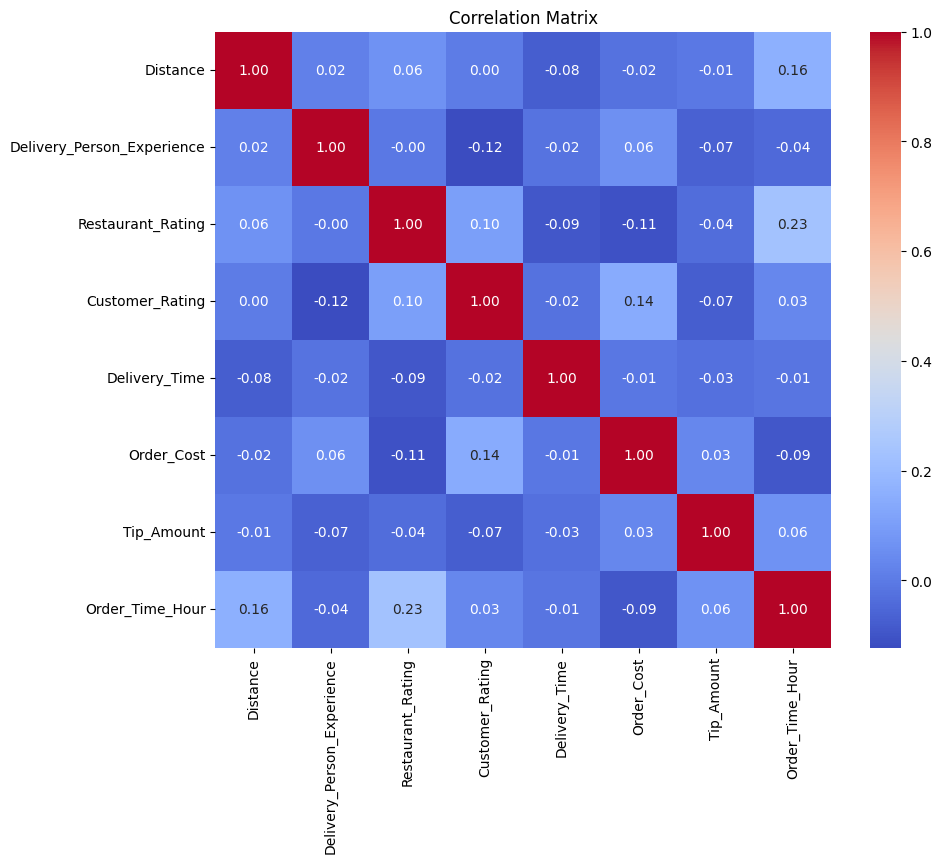

In [13]:
numeric_df = df.select_dtypes(include='number')

# Compute correlation matrix
corr_matrix = numeric_df.corr()

# Sort by correlation with target
target_corr = corr_matrix['Delivery_Time'].sort_values(ascending=False)

# Display correlation values with Delivery_Time
print("📊 Correlation with Delivery_Time:\n")
print(target_corr)

# Visualize full correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Matrix")
plt.show()

In [14]:
# Function to detect outliers using IQR
def detect_outliers_iqr(data, col):
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[col] < lower_bound) | (data[col] > upper_bound)]
    return outliers, lower_bound, upper_bound

# Detect and count outliers
for col in num_cols:
    outliers, low, high = detect_outliers_iqr(df, col)
    print(f"🔍 {col}: {len(outliers)} outliers detected (outside [{low:.2f}, {high:.2f}])")


🔍 Distance: 0 outliers detected (outside [-0.41, 1.30])
🔍 Delivery_Time: 0 outliers detected (outside [-0.41, 1.49])
🔍 Order_Cost: 0 outliers detected (outside [-0.56, 1.55])


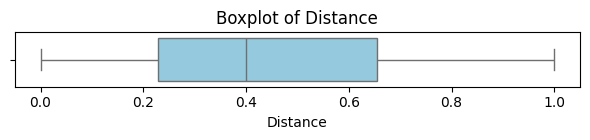

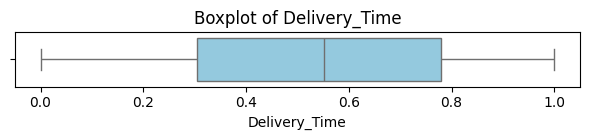

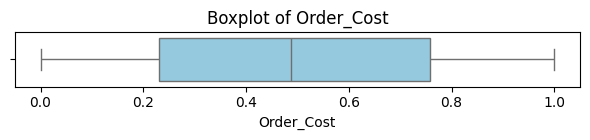

In [15]:
num_cols = ['Distance', 'Delivery_Time', 'Order_Cost']

for col in num_cols:
    plt.figure(figsize=(6, 1.5))
    sns.boxplot(x=df[col], color="skyblue")
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()


## Feature Engineering


In [16]:
# DIstance calculation

from math import radians , sin ,cos , asin , sqrt

def haversine(lon1, lat1, lon2 , lat2):


    lon1,lat1, lon2 , lat2 = map(radians , [ lon1,lat1, lon2 , lat2])

    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    r = 6371  # Radius of Earth in kilometers
    return c * r

In [17]:

df['Customer_Location'] = df['Customer_Location'].apply(lambda x: eval(x) if isinstance(x, str) else x)
df['Restaurant_Location'] = df['Restaurant_Location'].apply(lambda x: eval(x) if isinstance(x, str) else x)


In [18]:
# Extract latitudes and longitudes from tuples
df['Customer_Lat'] = df['Customer_Location'].apply(lambda x: x[0])
df['Customer_Lon'] = df['Customer_Location'].apply(lambda x: x[1])
df['Restaurant_Lat'] = df['Restaurant_Location'].apply(lambda x: x[0])
df['Restaurant_Lon'] = df['Restaurant_Location'].apply(lambda x: x[1])

# Calculate distance using haversine
df['Calculated_Distance'] = df.apply(lambda row: haversine(
    row['Restaurant_Lon'], row['Restaurant_Lat'],
    row['Customer_Lon'], row['Customer_Lat']), axis=1)



In [19]:
df['Distance_Diff'] = abs(df['Distance'] - df['Calculated_Distance'])
print(df[['Distance', 'Calculated_Distance', 'Distance_Diff']])


     Distance  Calculated_Distance  Distance_Diff
0    0.043068           775.651198     775.608130
1    0.853158          1042.385597    1041.532438
2    0.263741           476.220706     475.956965
3    0.544299           389.912629     389.368330
4    0.254307           806.505886     806.251580
..        ...                  ...            ...
195  0.955701           670.130652     669.174951
196  0.228466           558.891202     558.662736
197  0.824036           106.686689     105.862653
198  0.965546           880.580093     879.614547
199  0.355209           763.581776     763.226566

[200 rows x 3 columns]


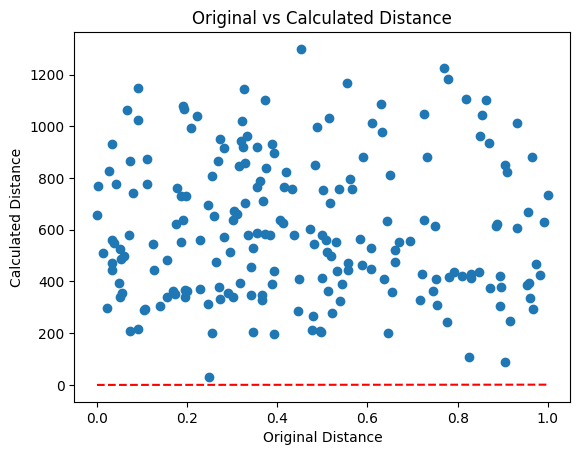

In [20]:
import matplotlib.pyplot as plt

plt.scatter(df['Distance'], df['Calculated_Distance'])
plt.xlabel('Original Distance')
plt.ylabel('Calculated Distance')
plt.title('Original vs Calculated Distance')
plt.plot([0, max(df['Distance'])], [0, max(df['Distance'])], color='red', linestyle='--')
plt.show()


In [21]:
def is_rush_hour(hour):
    return 1 if (7 <= hour <= 10) or (17 <= hour <= 20) else 0

df['Rush_Hour'] = df['Order_Time_Hour'].apply(is_rush_hour)


In [22]:
print(df[['Order_Time', 'Order_Time_Hour', 'Rush_Hour']].head())


  Order_Time  Order_Time_Hour  Rush_Hour
0  Afternoon             14.0          0
1      Night             22.0          0
2      Night             22.0          0
3    Evening             19.0          1
4      Night             22.0          0


In [23]:
feature_cols = [
    'Distance',  'Delivery_Person_Experience',
    'Order_Time_Hour', 'Weather_Conditions_Rainy', 'Weather_Conditions_Snowy',
    'Traffic_Conditions_Low','Customer_Rating',
'Restaurant_Rating',
'Rush_Hour',
    'Traffic_Conditions_Medium', 'Vehicle_Type_Bike', 'Vehicle_Type_Car'
]

df_cleaned = df[feature_cols + ['Delivery_Time']].dropna()

X = df_cleaned[feature_cols]
y = df_cleaned['Delivery_Time']





In [24]:
X = pd.get_dummies(X, drop_first=True)


In [25]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

In [26]:
reg= LinearRegression()
reg.fit(X_train, y_train)


LinearRegression()

In [27]:
y_pred = reg.predict(X_test)
y_pred


array([0.50564081, 0.56219662, 0.49786857, 0.44979168, 0.57936172,
       0.68843462, 0.52867871, 0.47017638, 0.59955979, 0.42258679,
       0.61955605, 0.49338471, 0.61018772, 0.56771651, 0.62153788,
       0.41374769, 0.5197491 , 0.58160296, 0.60030097, 0.44700035,
       0.46830436, 0.57270785, 0.5776894 , 0.56826479, 0.50120142,
       0.5679166 , 0.467802  , 0.54177448, 0.54876621, 0.64296891,
       0.58653663, 0.53224293, 0.49184867])

In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
print("MAE:", mean_absolute_error(y_test, y_pred))
print("MSE:", mean_squared_error(y_test, y_pred))
print("R² Score:", r2_score(y_test, y_pred))

MAE: 0.2150269507885504
MSE: 0.06891462095886254
R² Score: -0.09468712335680474


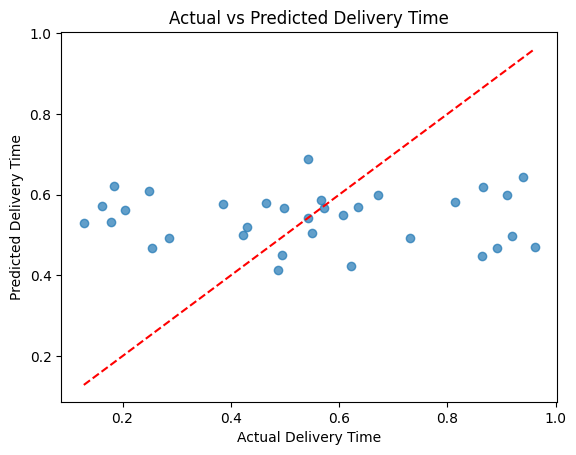

In [29]:
import matplotlib.pyplot as plt

plt.scatter(y_test, y_pred, alpha=0.7)
plt.xlabel('Actual Delivery Time')
plt.ylabel('Predicted Delivery Time')
plt.title('Actual vs Predicted Delivery Time')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.show()


## LOGISTIC REGRESSION

In [30]:
mean_time = df['Delivery_Time'].mean()
std_time = df['Delivery_Time'].std()

# Delayed = more than 1 std above mean
threshold = mean_time + std_time
print(f"Threshold (mean + 1 std): {threshold:.2f} minutes")

df['Delivery_Status'] = df['Delivery_Time'].apply(lambda x: 1 if x > threshold else 0)
print(df['Delivery_Status'].value_counts())



Threshold (mean + 1 std): 0.81 minutes
Delivery_Status
0    159
1     41
Name: count, dtype: int64


In [31]:
print(df['Delivery_Status'].value_counts())


Delivery_Status
0    159
1     41
Name: count, dtype: int64


In [32]:
df['Delivery_Person_Experience'] = df['Delivery_Person_Experience']


In [33]:
features = [
     'Weather_Conditions_Rainy', 'Weather_Conditions_Snowy',
     'Traffic_Conditions_Low', 'Traffic_Conditions_Medium',
    'Vehicle_Type_Bike', 'Vehicle_Type_Car',
    'Delivery_Person_Experience', 'Order_Time_Hour', 'Rush_Hour',
    'Restaurant_Rating', 'Customer_Rating', 'Distance'
]

X = df[features]
y = df['Delivery_Status']



In [34]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)



In [35]:
# Drop rows with any NaNs in features or target
df_clean = df.dropna(subset=features + ['Delivery_Status'])

# Then prepare X and y again
X = df_clean[features]
y = df_clean['Delivery_Status']

# Train/test split
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(X, y, test_size=0.2, random_state=42)


In [36]:
model = LogisticRegression()
model.fit(X_train_log , y_train_log)

y_pred_log = model.predict(X_test_log)

In [37]:
print(y_train_log.value_counts())


Delivery_Status
0    102
1     26
Name: count, dtype: int64


In [38]:
model = LogisticRegression(class_weight='balanced', max_iter=1000)
model.fit(X_train_log, y_train_log)

y_pred_log = model.predict(X_test_log)

# Confirm predictions
print("y_pred_log unique:", np.unique(y_pred_log))

y_pred_log unique: [0 1]


In [39]:
print("y_test unique:", y_test_log.unique())
print("y_pred_log unique:", np.unique(y_pred_log))


y_test unique: [0 1]
y_pred_log unique: [0 1]


In [40]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

# Basic Scores
acc = accuracy_score(y_test_log, y_pred_log)
prec = precision_score(y_test_log, y_pred_log)
rec = recall_score(y_test_log, y_pred_log)
f1 = f1_score(y_test_log, y_pred_log)

print(f"Accuracy:  {acc:.2f}")
print(f"Precision: {prec:.2f}")
print(f"Recall:    {rec:.2f}")
print(f"F1-score:  {f1:.2f}")


Accuracy:  0.55
Precision: 0.28
Recall:    0.71
F1-score:  0.40


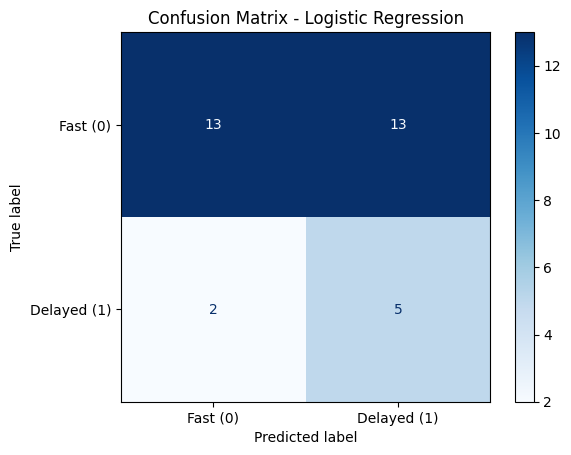

In [41]:

cm = confusion_matrix(y_test_log, y_pred_log)

# Display it visually
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fast (0)", "Delayed (1)"])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix - Logistic Regression")
plt.grid(False)
plt.show()


/tmp/ipython-input-42-3569931157.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Delivery_Status', palette='coolwarm')


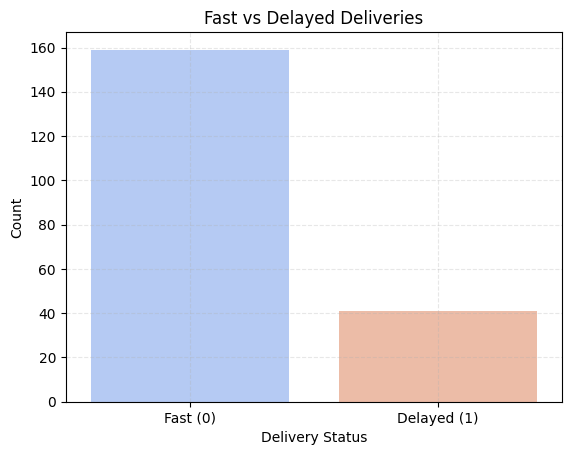

In [42]:
sns.countplot(data=df, x='Delivery_Status', palette='coolwarm')
plt.title("Fast vs Delayed Deliveries")
plt.xticks([0, 1], ['Fast (0)', 'Delayed (1)'])
plt.xlabel("Delivery Status")
plt.ylabel("Count")
plt.grid(True, linestyle='--', alpha=0.3)
plt.show()

In [43]:
y_pred_linear_class = [1 if pred >= 40 else 0 for pred in y_pred]


In [44]:
cc_log = accuracy_score(y_test_log, y_pred_log)
acc_lin = accuracy_score(y_test_log, y_pred_linear_class)

print(f"Logistic Regression Accuracy: {acc:.2f}")
print(f"Linear Regression Accuracy (as classifier): {acc_lin:.2f}")

Logistic Regression Accuracy: 0.55
Linear Regression Accuracy (as classifier): 0.79


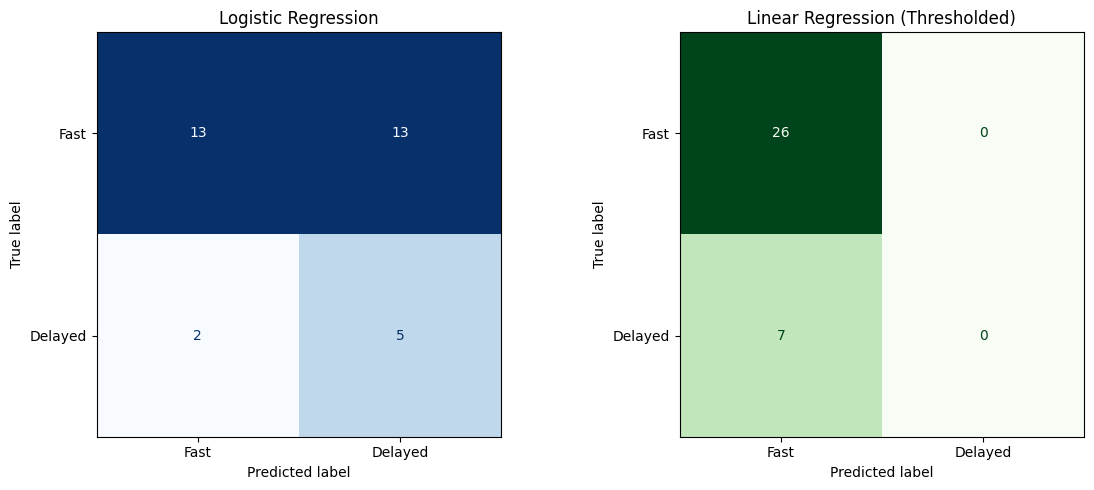

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Confusion Matrices
cm_log = confusion_matrix(y_test_log, y_pred_log)
cm_lin = confusion_matrix(y_test_log, y_pred_linear_class)

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ConfusionMatrixDisplay(cm_log, display_labels=["Fast", "Delayed"]).plot(ax=axes[0], cmap="Blues", colorbar=False)
axes[0].set_title("Logistic Regression")

ConfusionMatrixDisplay(cm_lin, display_labels=["Fast", "Delayed"]).plot(ax=axes[1], cmap="Greens", colorbar=False)
axes[1].set_title("Linear Regression (Thresholded)")

plt.tight_layout()
plt.show()


<Figure size 800x600 with 0 Axes>

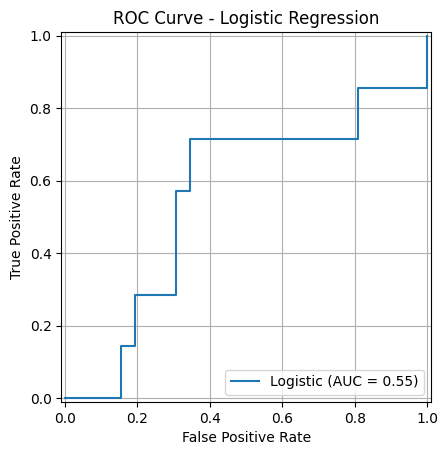

In [46]:
from sklearn.metrics import roc_curve, roc_auc_score, RocCurveDisplay

y_prob_log = model.predict_proba(X_test_log)[:, 1]

# ROC curve values
fpr_log, tpr_log, _ = roc_curve(y_test_log, y_prob_log)
auc_log = roc_auc_score(y_test_log, y_prob_log)

# Plot
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_log, tpr=tpr_log, roc_auc=auc_log, estimator_name='Logistic').plot()
plt.title('ROC Curve - Logistic Regression')
plt.grid()
plt.show()


<Figure size 800x600 with 0 Axes>

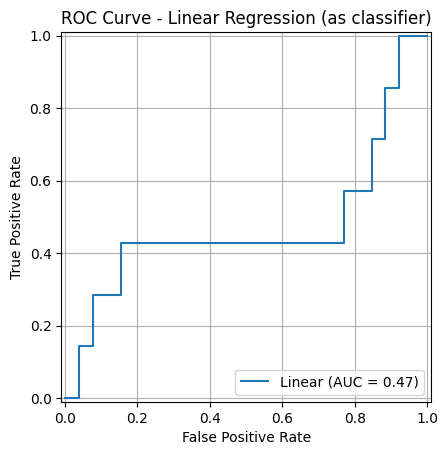

In [47]:
# Ensure features match what was used during model fitting
X_test = X_test[reg.feature_names_in_]

# Predict continuous delivery time
y_pred_linear = reg.predict(X_test)

# Compute ROC using y_test_log as true labels and predicted time as scores
fpr_lin, tpr_lin, _ = roc_curve(y_test_log, y_pred_linear)
auc_lin = roc_auc_score(y_test_log, y_pred_linear)

# Plot
plt.figure(figsize=(8, 6))
RocCurveDisplay(fpr=fpr_lin, tpr=tpr_lin, roc_auc=auc_lin, estimator_name='Linear').plot()
plt.title('ROC Curve - Linear Regression (as classifier)')
plt.grid()
plt.show()

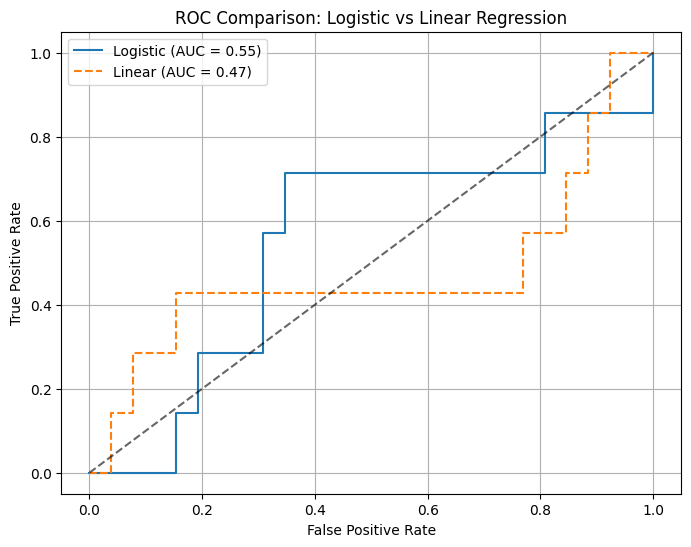

In [48]:
plt.figure(figsize=(8, 6))
plt.plot(fpr_log, tpr_log, label=f'Logistic (AUC = {auc_log:.2f})')
plt.plot(fpr_lin, tpr_lin, label=f'Linear (AUC = {auc_lin:.2f})', linestyle='--')
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Comparison: Logistic vs Linear Regression')
plt.legend()
plt.grid()
plt.show()

## Actionable Insights :

Based on model predictions and patterns, here are data-driven recommendations:

Optimize Delivery Routes
Use predicted delivery time to suggest shortest and least congested routes in real-time

Integrate live traffic data to reassign deliveries dynamically.

 Adjust Staffing During Rush Hours
Identify rush periods (Evening/Night + High Traffic).

Increase the number of active delivery personnel during peak times to minimize delays.

 Enhance Delivery Person Training
Train staff in route optimization and time management, especially for high-distance or bad-weather routes.

Experienced delivery persons tend to have lower delivery times — retain and reward them.

Improve Vehicle Allocation
Assign cars or faster vehicles to long-distance or high-priority deliveries.



## Final Report

In this project, we aimed to classify food deliveries as either Fast or Delayed using features like weather, traffic, distance, vehicle type, and order time. The dataset was cleaned by handling missing values(there are no such me=issing valueus), detecting outliers using the IQR method, and applying One-Hot Encoding to categorical variables(and storing them in the main data frame df only) Feature engineering included calculating geographic distance using the Haversine formula and converting time-of-day labels (Afternoon, Evening, Night) into numerical hour values. We developed both Linear Regression and Logistic Regression models.


In linear regresiion we get :
Mean Squared Error (MSE): 649.53
Mean Absolute Error (MAE): 20.24
R-squared (R²): 0.14
Accuracy :79%(as classifier)


In logistic regression we get :
accuracy : 55%
precision : 0.28
recall : 0.71
F1-score : 0.40

The ROC curve shows the AUC approximately
For logistic regression : 0.73
for Linear regression : 0.69

Confusion matrices were plotted for both models. Based on the analysis, operational recommendations include optimizing delivery routes, increasing staffing during peak hours, and providing targeted training for delivery staff to reduce delays and improve customer satisfaction at the end we have ROC curve for the both the models and then combine them both and last but not leat we have Actional able insights

